In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import imutils
import itertools
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from tqdm import tqdm

import keras
import tensorflow as tf

from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential


random_seed = 123

In [ ]:
!unrar x '/content/drive/MyDrive/COLAB/calismalar/BrainTumorDiagnosis(Classification)/brain_tumor_dataset.rar' '/content'

##Data Preprocessing

In [4]:
!mkdir /content/train
!mkdir /content/test
!mkdir /content/val
!mkdir /content/train/YES
!mkdir /content/train/NO
!mkdir /content/test/YES
!mkdir /content/test/NO
!mkdir /content/val/YES
!mkdir /content/val/NO

In [6]:
img_path = '/content/brain_tumor_dataset'
#datayı train test val olarak bölme

for CLASS in os.listdir(img_path):
  if not CLASS.startswith('.'):
    img_num = len(os.listdir(img_path + '/' + CLASS))
    for (n, filename) in enumerate(os.listdir(img_path + '/' + CLASS)):
      img = img_path + '/' + CLASS + '/' + filename
      if n < 5:
        shutil.copy(img, 'test/' + CLASS.upper() + '/' + filename)
      elif n < 0.8*img_num:
        shutil.copy(img, 'train/' + CLASS.upper() + '/' + filename)
      else:
        shutil.copy(img, 'val/' + CLASS.upper() + '/' + filename)


In [7]:
def load_data(dir_path, img_size=(100,100)):
  X=[]
  y=[]
  i=0
  labels=dict()
  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('.'):
      labels[i] = path
      for file in os.listdir(dir_path + path):
        if not file.startswith('.'):
          img = cv2.imread(dir_path + path + '/' + file)
          X.append(img)
          y.append(i)
      i += 1
  X = np.array(X)
  y = np.array(y)
  print(f'{len(X)} images loaded from {dir_path} directory.')
  return X, y, labels
  

In [9]:
train_dir = '/content/train/'
test_dir = '/content/test/'
val_dir = '/content/val/'
img_size = (224, 224)

x_train, y_train, labels = load_data(train_dir, img_size)
x_test, y_test, _ = load_data(test_dir, img_size)
x_val, y_val, _ = load_data(val_dir, img_size)

100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



193 images loaded from /content/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 106.18it/s]


10 images loaded from /content/test/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]

50 images loaded from /content/val/ directory.


In [10]:
def plot_samples(X, y, labels_dict, n=50):
  for index in range(len(labels_dict)):
    imgs=X[np.argwhere(y == index)][:n]
    j = 10
    i = int(n/j)

    plt.figure(figsize=(15,6))
    c = 1

    for img in imgs:
      plt.subplot(i,j,c)
      plt.imshow(img[0])

      plt.xticks([])
      plt.yticks([])

      c+=1
    plt.suptitle('Tumor: {}'.format(labels_dict[index]))
    plt.show()

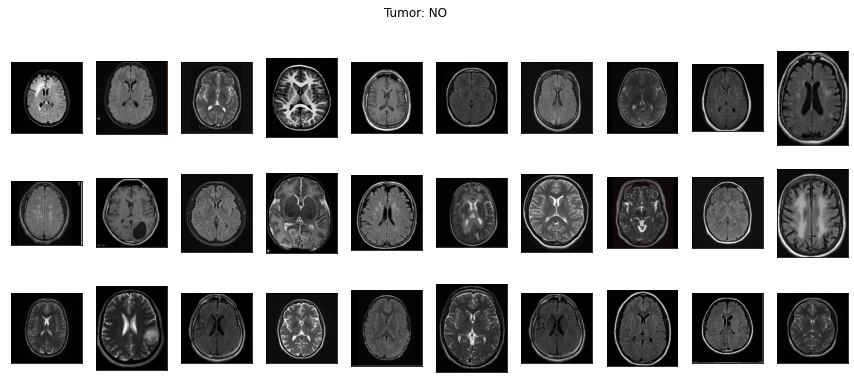

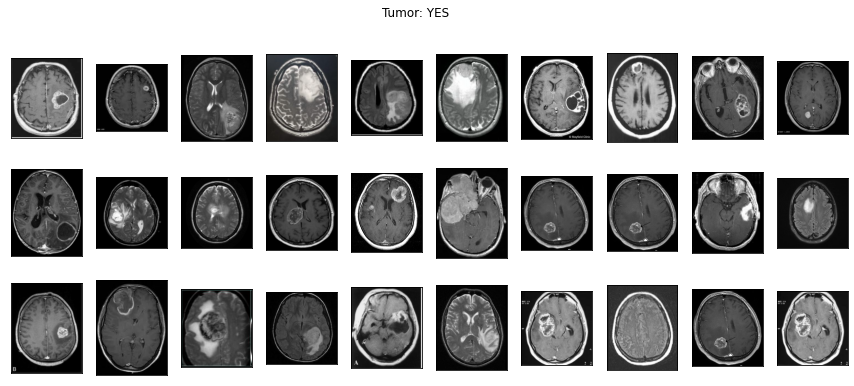

In [11]:
plot_samples(x_train, y_train, labels, 30)

##Data normalization

Tüm resimler farklı en ve farklı boya sahip sınıflandırma yaparken asıl beyin kısmını kırpıp tüm resimleri aynı en boy oranına getirdik.

In [12]:
def crop_images(set_name, add_pixels_value=0):
  set_new=[]
  for img in set_name:
    gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2) #erozyon
    thresh = cv2.dilate(thresh, None, iterations=2) #küçük gürültü bölgelerini ortadan kaldırmak için genişlemeler
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    add_pixels = add_pixels_value
    new_img = img[extTop[1] - add_pixels:extBot[1]+add_pixels, extLeft[0]-add_pixels:extRight[0]+add_pixels].copy()
    set_new.append(new_img)
  return np.array(set_new)

In [13]:
x_train_crop = crop_images(set_name=x_train)
x_val_crop = crop_images(set_name=x_val)
x_test_crop = crop_images(set_name=x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



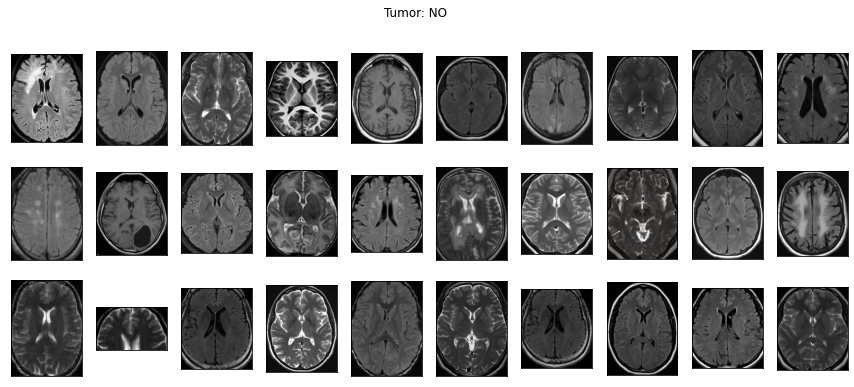

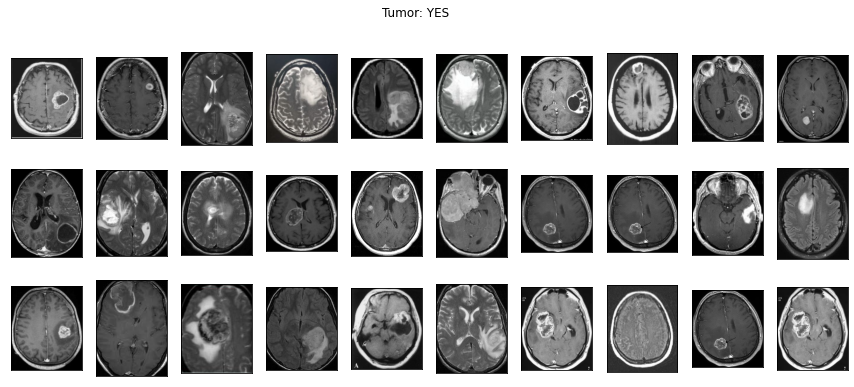

In [14]:
plot_samples(x_train_crop, y_train, labels, 30)

oluşan yeni resimleri kaydedelim

In [15]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

In [16]:
def save_new_images(x_set, y_set, foldername):
  i=0
  for (img, imclass) in zip(x_set, y_set):
    if imclass == 0:
      cv2.imwrite(foldername+'NO/'+ str(i) + '.jpg', img)
    else:
      cv2.imwrite(foldername + 'YES/' + str(i) + '.jpg', img)
    i+=1

In [17]:
save_new_images(x_train_crop, y_train, foldername='TRAIN_CROP/')
save_new_images(x_test_crop, y_test, foldername='TEST_CROP/')
save_new_images(x_val_crop, y_val, foldername='VAL_CROP/')

resimleri resize et

In [18]:
def preprocess_images(set_name, img_size):
  set_new=[]
  for img in set_name:
    img = cv2.resize(img,
                     dsize=img_size,
                     interpolation=cv2.INTER_CUBIC)
    set_new.append(preprocess_input(img))
  return np.array(set_new)

In [19]:
x_train_prep = preprocess_images(set_name = x_train_crop, img_size=img_size)
x_val_prep = preprocess_images(set_name = x_val_crop, img_size=img_size)
x_test_prep = preprocess_images(set_name = x_test_crop, img_size=img_size)

In [ ]:
plot_samples(x_train_prep, y_train, labels, 30)

##Model Oluşturma

In [21]:
train_dir = '/content/TRAIN_CROP'
val_dir = '/content/VAL_CROP'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size = 32,
    class_mode='binary',
    seed=random_seed
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size = 32,
    class_mode='binary',
    seed=random_seed
)


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [22]:
vgg16_weights_path = '/content/drive/MyDrive/COLAB/calismalar/BrainTumorDiagnosis(Classification)/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights = vgg16_weights_path,
    include_top=False,
    input_shape = img_size +(3, )
)

In [29]:
num_classes = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
len(os.listdir('/content/VAL_CROP/NO'))

19

In [28]:
len(x_train_prep)//batch_size

6

In [30]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<1.5):
      print("\nReached ")
      self.model.stop_training = True

callbacks = myCallback()

In [31]:
batch_size = 32
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train_prep)//batch_size,
    epochs=50,
    validation_data = validation_generator,
    validation_steps=len(x_val_prep)//batch_size,
    callbacks=[callbacks]
)

Epoch 1/50
6/6 [==============================] - 5s 677ms/step - loss: 5.9830 - accuracy: 0.5652 - val_loss: 2.9653 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 4s 571ms/step - loss: 6.1863 - accuracy: 0.5217 - val_loss: 3.5350 - val_accuracy: 0.4688
Epoch 3/50
6/6 [==============================] - 4s 569ms/step - loss: 4.1986 - accuracy: 0.6087 - val_loss: 3.2594 - val_accuracy: 0.5938
Epoch 4/50
6/6 [==============================] - 4s 560ms/step - loss: 3.4989 - accuracy: 0.6770 - val_loss: 4.4967 - val_accuracy: 0.4062
Epoch 5/50
6/6 [==============================] - 4s 574ms/step - loss: 4.1554 - accuracy: 0.6025 - val_loss: 3.6107 - val_accuracy: 0.5312
Epoch 6/50
6/6 [==============================] - 4s 659ms/step - loss: 3.2960 - accuracy: 0.6771 - val_loss: 3.5779 - val_accuracy: 0.5000
Epoch 7/50
6/6 [==============================] - 4s 600ms/step - loss: 3.7066 - accuracy: 0.6957 - val_loss: 3.9866 - val_accuracy: 0.5312
Epoch 8/50
6/6 [====

In [32]:
model.save(f'brainTumorDiagnose3.h5') 

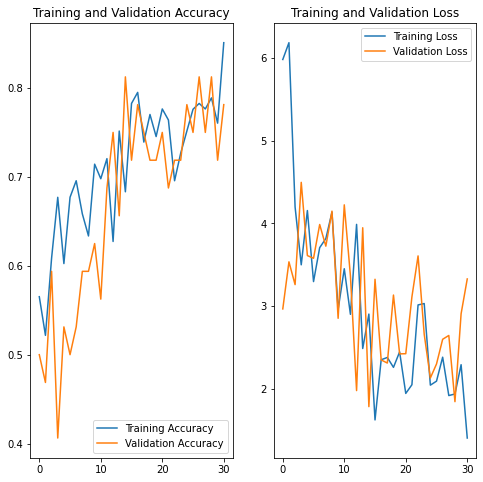

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Test

In [35]:
labels

{0: 'NO', 1: 'YES'}

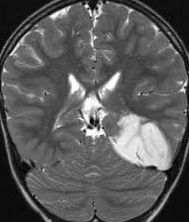

In [36]:
img_url='/content/TEST_CROP/YES/5.jpg'
PIL.Image.open(img_url)

In [37]:
img = tf.keras.preprocessing.image.load_img(img_url, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions =model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(f"This image most likely belongs to {labels[np.argmax(score)]} with a {100 * np.max(score)} percent confidence.") 

This image most likely belongs to NO with a 100.0 percent confidence.


In [55]:
predictions = model.predict(x_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 0.80


In [60]:
predictions = np.array(predictions)

In [62]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

